# Capstone Project: The Persuasive Power of Words

*by Nee Bimin*

## Notebook 2: Exploratory Data Analysis

In this notebook, there will be data visualisations to explore the variables available in the dataset. We will follow up with Collaborative Topic Modeling in the next notebook.

## Content
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Ratings EDA](#Ratings-EDA)
    * [Ratings and TED Talks EDA](#Ratings-and-TED-Talks-EDA)
    * [Ratings, Tags and Speaker Occupation EDA](#Ratings,-Tags-and-Speaker-Occupation-EDA)
    * [Persuasive and Inspiring EDA](#Persuasive-and-Inspiring-EDA)
    

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib_venn_wordcloud import venn2_wordcloud, venn3_wordcloud
from matplotlib_venn import venn2
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

In [2]:
# Read in data
ted = pd.read_csv('../data/ted_cleaned.csv')
ratings = pd.read_csv('../data/ratings.csv')
occupations = pd.read_csv('../data/occupations.csv')
tags = pd.read_csv('../data/tags.csv')
ted_model = pd.read_csv('../data/ted_model.csv')

## Exploratory Data Analysis

### Ratings EDA

In [3]:
ratings.head()

,funny,beautiful,ingenious,courageous,longwinded,confusing,informative,fascinating,unconvincing,persuasive,jaw_dropping,ok,obnoxious,inspiring,total,positive,negative,talk_id
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924,93850,91538,1138,1
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413,2936,2169,564,2
2,964,60,183,45,78,27,395,166,104,230,54,146,142,230,2824,2327,351,3
3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070,3728,3487,156,4
4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893,25620,25062,310,5


The plot below shows the number of positive, neutral (OK) and negative ratings.

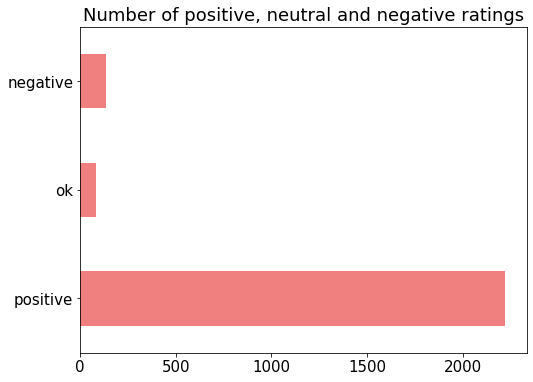

In [4]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
ratings[['positive', 'ok', 'negative']].mean().plot(kind='barh', color='lightcoral')
plt.title('Number of positive, neutral and negative ratings');

Now we will look at the breakdown of ratings voted for.

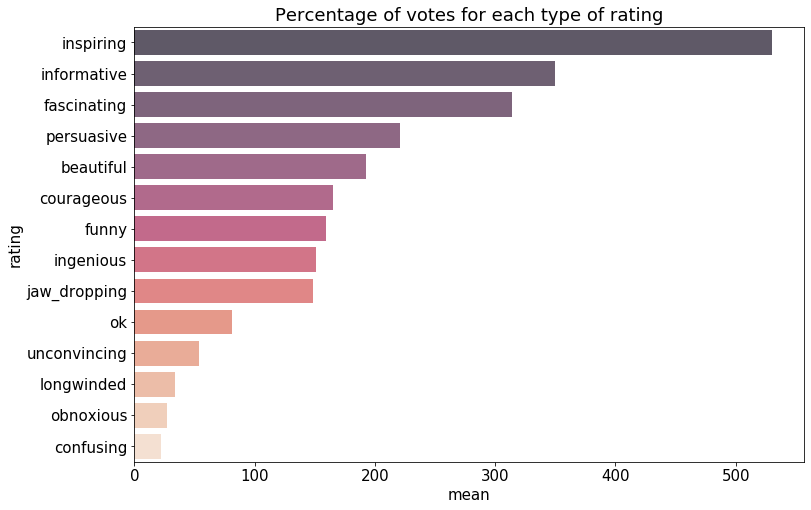

In [5]:
count_talks = defaultdict(list)
for rating in ratings.columns:
    if (rating != 'talk_id') & (rating != 'total') & (rating != 'positive') & (rating != 'negative'):
        count_talks['rating'].append(rating) 
        count_talks['mean'].append(ratings[ratings[rating] > 0][rating].mean())

count_talks = pd.DataFrame(count_talks).sort_values('mean', ascending = False)

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
sns.barplot(x="mean", y="rating", data=count_talks, palette='rocket', alpha=0.7)
plt.title('Percentage of votes for each type of rating');

As expected, the more positive rating categories are voted for more frequently, e.g. inspiring, informative and fascinating. 

Next let's look at the most popular talks in terms of number of votes and compare whether the most-voted-for talks are the ones that received the greater percentage of positive votes i.e. let us check out the correlation. 

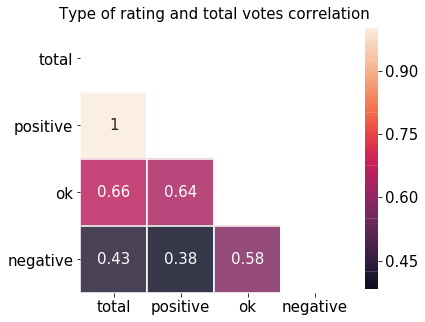

In [6]:
votes = ratings[['total', 'positive', 'ok', 'negative']].sort_values('total', ascending=False)

#Plot correlations on a heatmap
fig, ax = plt.subplots(figsize = (6,6))
plt.title('Type of rating and total votes correlation', fontsize = 15)
votes_corr = votes.corr()

#Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(votes_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
ax = sns.heatmap(votes_corr, mask=mask, cmap='rocket', alpha=0.8, annot = True, ax=ax, 
                 square=True, cbar_kws={"shrink": .8}, linewidths=.5)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=15)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), rotation='horizontal', fontsize=15);

The number of votes is very highly correlated with the number of positive votes, indicating that voters who vote will vote when the talk is good.

A new column, 'top_rating' will be creating in the ratings dataframe, consisting of the category of rating that is most voted for for each talk.

In [7]:
rating_cats = ratings[['funny', 'beautiful', 'ingenious', 'courageous', 'longwinded',
       'confusing', 'informative', 'fascinating', 'unconvincing', 'persuasive',
       'jaw_dropping', 'ok', 'obnoxious', 'inspiring']]

# Get the rating with the highest number of votes
ratings['top_rating'] = rating_cats.apply(lambda x: rating_cats.columns[x.argmax()], axis = 1)
ratings.head()

,funny,beautiful,ingenious,courageous,longwinded,confusing,informative,fascinating,unconvincing,persuasive,jaw_dropping,ok,obnoxious,inspiring,total,positive,negative,talk_id,top_rating
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924,93850,91538,1138,1,inspiring
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413,2936,2169,564,2,funny
2,964,60,183,45,78,27,395,166,104,230,54,146,142,230,2824,2327,351,3,funny
3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070,3728,3487,156,4,inspiring
4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893,25620,25062,310,5,informative


Before we check out the relationship between the top ratings and other variables in the main dataframe, we can first look at the most popular top ratings for each talk.

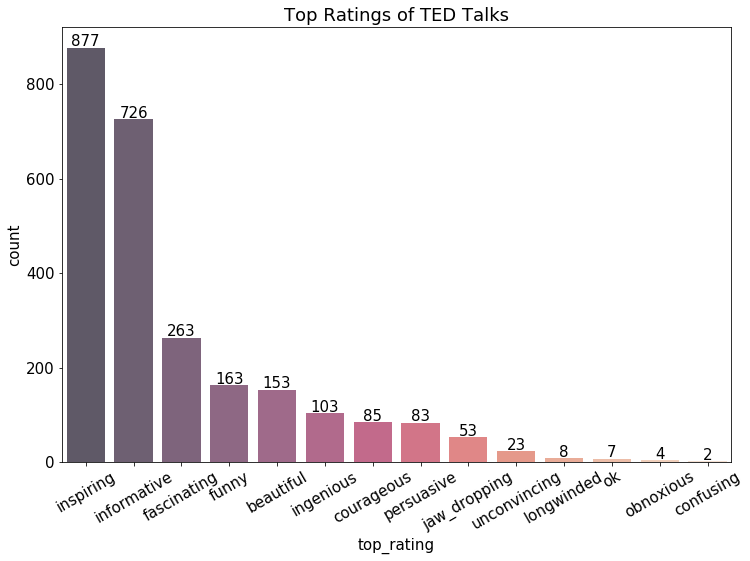

In [8]:
label_order = ratings['top_rating'].value_counts().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x = 'top_rating', data = ratings, order = label_order, alpha=0.7, palette='rocket')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:d}'.format(height),
            ha="center") 
plt.xticks(rotation=30)
plt.title('Top Ratings of TED Talks');

Inspiring, informative and fascinating, which are also the ratings most voted for, are unsurprisingly also the ratings that best describe most of the talks.

Persuasive is the top rating for only 53 of the talks while unconvincing best describes 8 of the talks.

### Ratings and TED Talks EDA

We can now check the relationship between the total votes and the other variables in the main dataframe e.g. number of views of the talks, number of comments, etc.

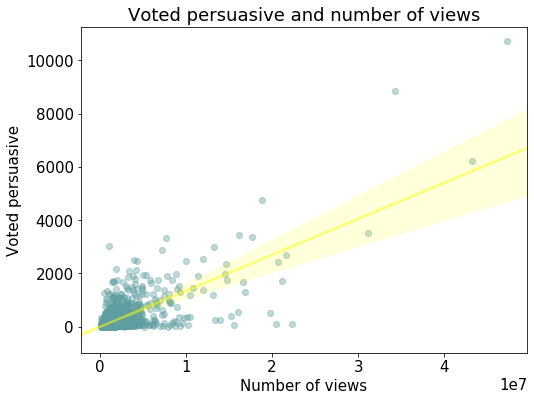

In [9]:
plt.figure(figsize=(8,6))
sns.regplot(x='views', y='persuasive', data=ted_model, scatter_kws={'color': 'cadetblue', 'alpha':0.4}, 
            line_kws={'color': 'yellow', 'alpha':0.5})
plt.xlabel("Number of views")
plt.ylabel("Voted persuasive")
plt.title('Voted persuasive and number of views');

There seems to be a linear relationship between the number of votes for persuasive and the number of views.
The higher the number of views, the higher the number of votes for persuasiveness, which makes sense because viewers have to watch the talk before rating it. But the causation could run both ways.

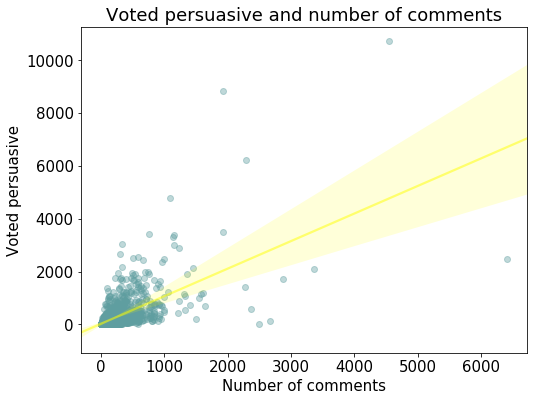

In [10]:
plt.figure(figsize=(8,6))
sns.regplot(x='comments', y='persuasive', data=ted_model, scatter_kws={'color': 'cadetblue', 'alpha':0.4}, 
            line_kws={'color': 'yellow', 'alpha':0.5})
plt.xlabel('Number of comments')
plt.ylabel('Voted persuasive')
plt.title('Voted persuasive and number of comments');

The number of comments and persuasive votes are also positively correlated. The number of comments are lower than the number of votes. Note that there is one particular talk with a relatively low number of ratings but high number of comments. We will check that out below.

In [11]:
ted_model[ted_model['comments'] > 6000]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,persuasive,inspiring,unconvincing,norm_persuasive,norm_inspiring,norm_unconvincing,transcript,persuasive_label,inspiring_label,unconvincing_label
95,6404,Richard Dawkins urges all atheists to openly s...,29.166667,TED2002,1970-01-01 00:00:01.012608000,42,Richard Dawkins,Richard Dawkins: Militant atheism,1,1970-01-01 00:00:01.176689220,...,2475,2935,539,0.000566,0.000671,0.000123,splendid music coming music elephant march aid...,1,1,1


The number of comments is perhaps unsurprising because of controversial the nature of the topic of religion, or rather, atheism. This could be the reason for the higher number of comments relative to the lower number of votes.

We can also check out the talk with the highest number of persuasive votes.

In [12]:
ted_model[ted_model['persuasive'] > 10000]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,persuasive,inspiring,unconvincing,norm_persuasive,norm_inspiring,norm_unconvincing,transcript,persuasive_label,inspiring_label,unconvincing_label
0,4553,Sir Ken Robinson makes an entertaining and pro...,19.4,TED2006,1970-01-01 00:00:01.140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1970-01-01 00:00:01.151367060,...,10704,24924,300,0.000227,0.000528,0.000006,good morning great ive blown away whole thing ...,1,1,1


Ken Robinson is the speaker of the most persuasive talk. It is indeed among the most-watched talks up till now, perhaps because of the persuasiveness of the talk that increased its popularity.


Next, we check out the number of comments and views for each top rating to compare the persuasive, inspiring and unconvincing talks against other talks.

In [13]:
# Merge the main TED Talks dataframe with the ratings dataframe
ratings_ted = ted.merge(ratings, how = 'left', on = ['talk_id'])

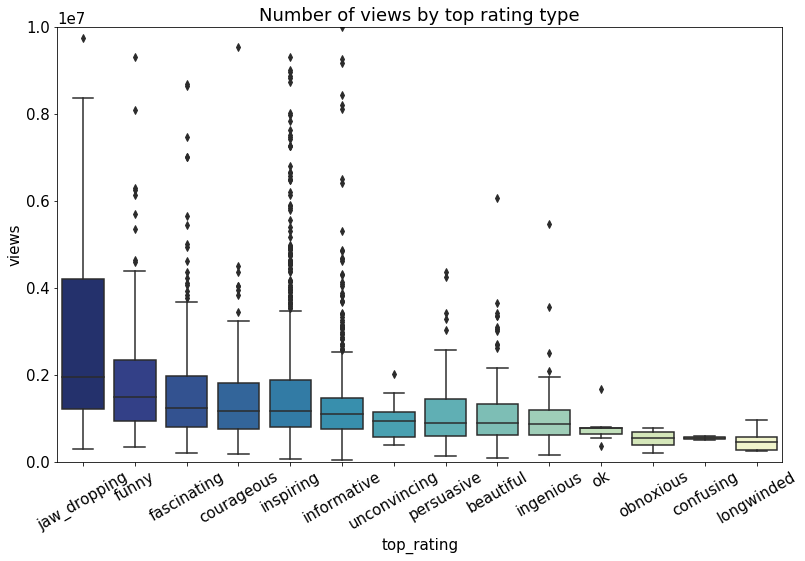

In [14]:
median_views = ratings_ted.groupby('top_rating')['views'].median().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(13,8))
ax = sns.boxplot(x='top_rating', y='views', data=ratings_ted, order=median_views, palette='YlGnBu_r')
plt.xticks(rotation=30)
plt.ylim((0,10000000))
plt.title('Number of views by top rating type');

Interestingly, unconvincing talks have a higher median number of views than persuasive talks. Among the three, inspiring talks have the highest number of views and has a very large number of outliers. 

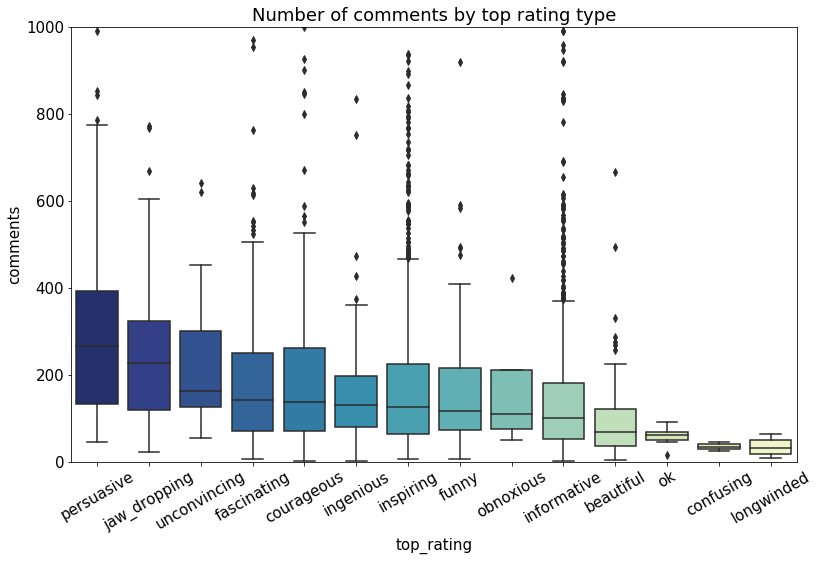

In [15]:
median_comments = ratings_ted.groupby('top_rating')['comments'].median().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(13,8))
ax = sns.boxplot(x='top_rating', y='comments', data=ratings_ted, order=median_comments, palette='YlGnBu_r')
plt.xticks(rotation=30)
plt.ylim((0,1000))
plt.title('Number of comments by top rating type');

The median number of comments are the highest for persuasive, with unconvincing lagging not far behind. Inspiring on the other hand, has the lowest number of comments among the three.
Unconvincing talks has so performed rather well in terms of drawing comments and votes. It definitely leaves an impression among its viewers, but perhaps for the wrong reasons.

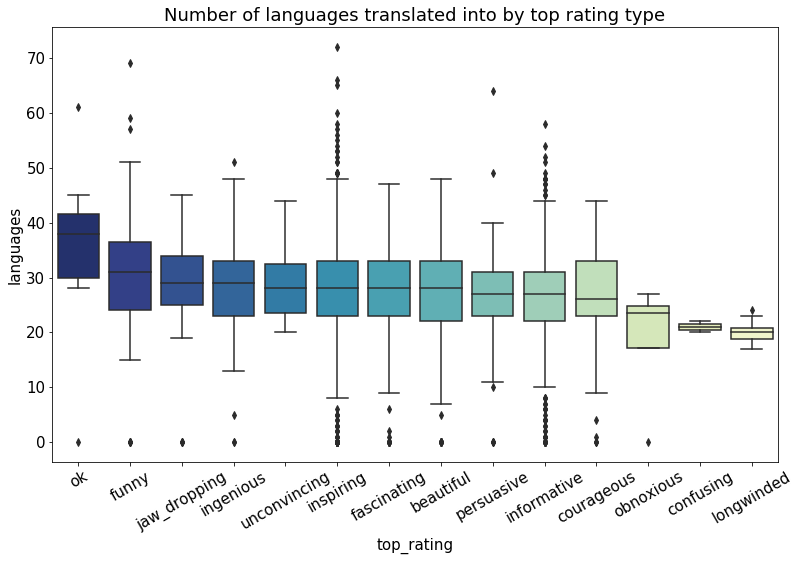

In [16]:
median_lang = ratings_ted.groupby('top_rating')['languages'].median().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(13, 8))
ax = sns.boxplot(x='top_rating', y='languages', data=ratings_ted, order=median_lang, palette='YlGnBu_r')
plt.xticks(rotation=30)
plt.title('Number of languages translated into by top rating type');

Talks rated 'ok' are the ones that are translated into the highest number of languages. For the rest of the talks (including persuasive, unconvincing and inspiring), they hover around the 30-language mark. The talks with the biggest number of outliers are inspiring and informative talks.

Next up is the type of talks versus the duration. We suspect that the long-winded talks are the ones with the longest duration.

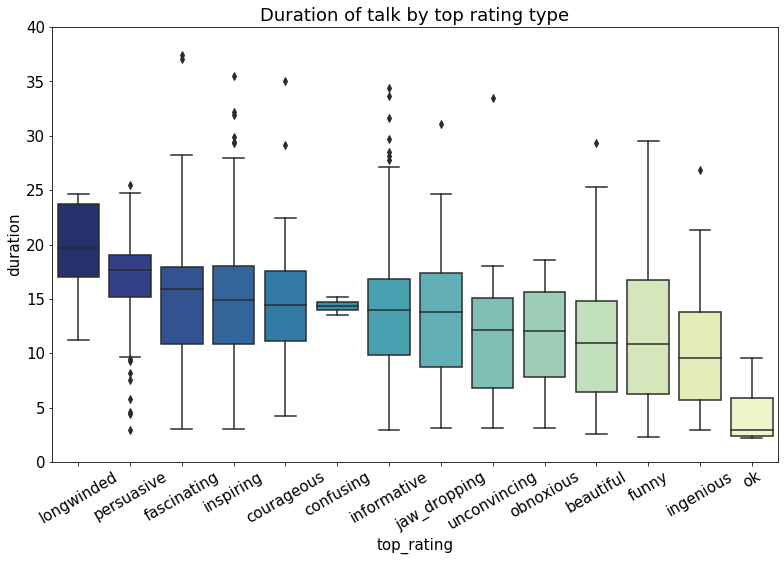

In [17]:
median_duration = ratings_ted.groupby('top_rating')['duration'].median().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(13,8))
ax = sns.boxplot(x='top_rating', y='duration', data=ratings_ted, order=median_duration, palette='YlGnBu_r')
plt.xticks(rotation=30)
plt.ylim((0,40))
plt.title('Duration of talk by top rating type');

As expected, the long-winded talks are indeed the most lengthy. Persuasive talks have the second longest duration. This suggests that there could be a thin line (2 to 3 minutes) of separation between persuasive and long-winded talks. Most of the talks fall between the 10- to 15-minute range. Perhaps the 'ok' talks were to short to leave an impression on whether it is negative or positive.

### Ratings, Tags and Speaker Occupation EDA

In [18]:
# Merge the data sets tags and ratings, and occupations and ratings
tags_ratings = ratings.merge(tags, how='left', on=['talk_id'])
occupations_ratings = ratings.merge(occupations, how='left', on=['talk_id'])

We can now find the tags and occupations most associated with persuasive, inspiring and unconvincing talks. 

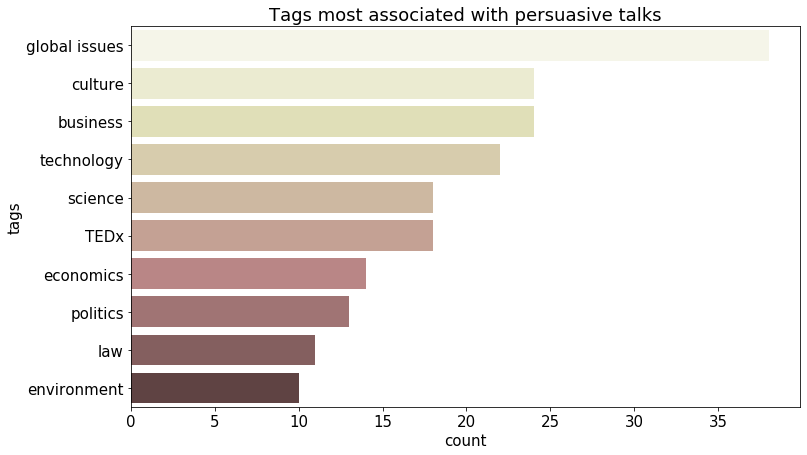

In [19]:
persuasive_tags = tags_ratings[tags_ratings['top_rating'] == 'persuasive'][['top_rating', 'tags']]
top_persuasive_tags = persuasive_tags.groupby('tags').count().sort_values('top_rating', ascending=False).head(10)
top_persuasive_tags.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='tags', x='top_rating', data=top_persuasive_tags, palette='pink_r' )
plt.title('Tags most associated with persuasive talks')
plt.xlabel('count');

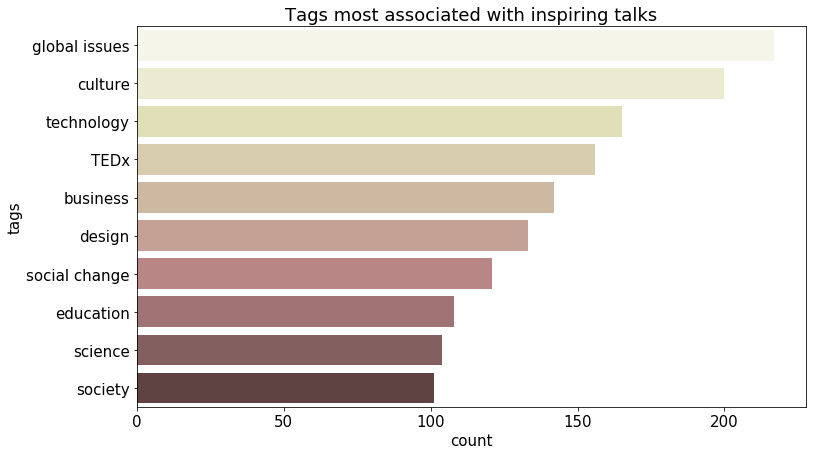

In [20]:
inspiring_tags = tags_ratings[tags_ratings['top_rating'] == 'inspiring'][['top_rating', 'tags']]
top_inspiring_tags = inspiring_tags.groupby('tags').count().sort_values('top_rating', ascending=False).head(10)
top_inspiring_tags.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='tags', x='top_rating', data=top_inspiring_tags, palette='pink_r' )
plt.title('Tags most associated with inspiring talks')
plt.xlabel('count');

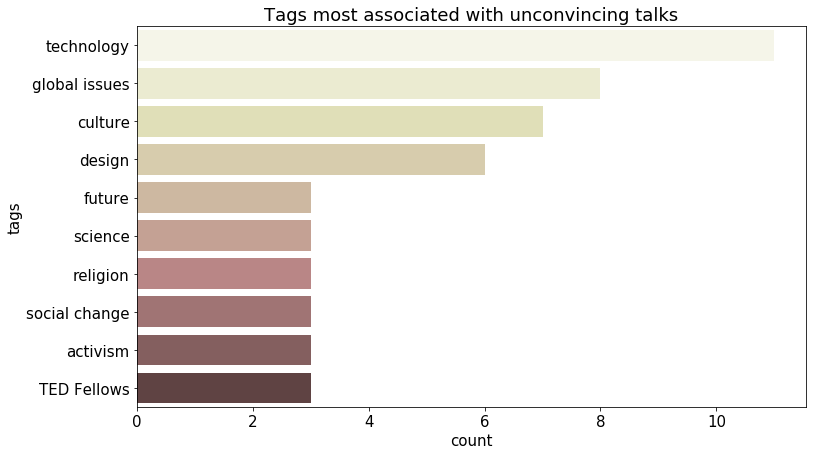

In [21]:
unconvincing_tags = tags_ratings[tags_ratings['top_rating'] == 'unconvincing'][['top_rating', 'tags']]
top_unconvincing_tags = unconvincing_tags.groupby('tags').count().sort_values('top_rating', ascending=False).head(10)
top_unconvincing_tags.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='tags', x='top_rating', data=top_unconvincing_tags, palette='pink_r' )
plt.title('Tags most associated with unconvincing talks')
plt.xlabel('count');

It is interesting to note that the top two tags related persuasive and inspiring are global issues and culture. At the same time, global issues and culture are also in the top three tags for unconvincing talks. Technology is also a popular tag associated with all the three ratings.
Tags may not be the reason for the difference between what makes a talk persuasive or not. The tags could simply reveal the trend of talks for that period of time. 

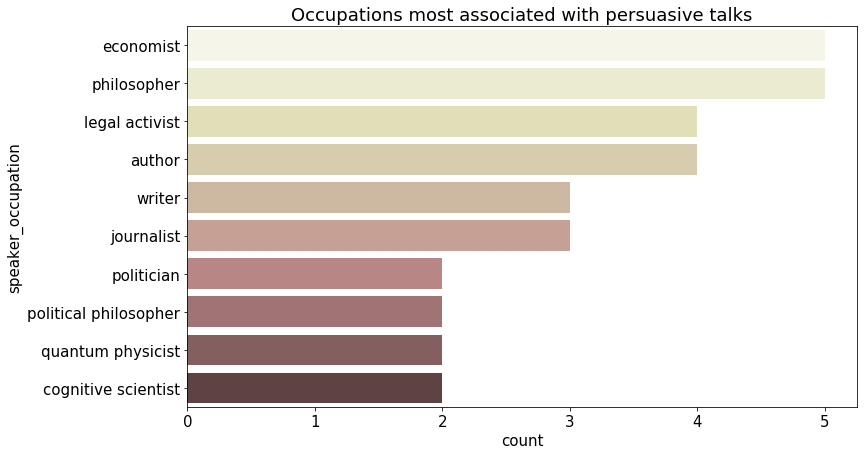

In [22]:
persuasive_occupations = occupations_ratings[occupations_ratings['top_rating'] == 'persuasive'][['top_rating', 'speaker_occupation']]
top_persuasive_occupations = persuasive_occupations.groupby('speaker_occupation').count().sort_values('top_rating', ascending=False).head(10)
top_persuasive_occupations.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='speaker_occupation', x='top_rating', data=top_persuasive_occupations, palette='pink_r' )
plt.title('Occupations most associated with persuasive talks')
plt.xlabel('count');

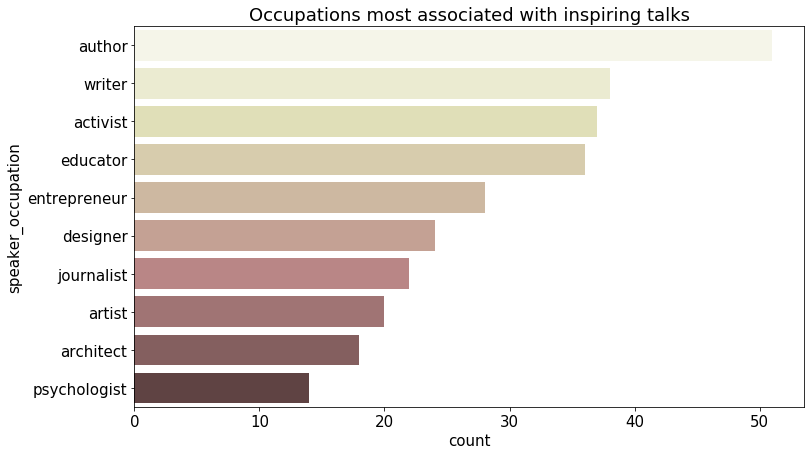

In [23]:
inspiring_occupations = occupations_ratings[occupations_ratings['top_rating'] == 'inspiring'][['top_rating', 'speaker_occupation']]
top_inspiring_occupations = inspiring_occupations.groupby('speaker_occupation').count().sort_values('top_rating', ascending=False).head(10)
top_inspiring_occupations.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='speaker_occupation', x='top_rating', data=top_inspiring_occupations, palette='pink_r' )
plt.title('Occupations most associated with inspiring talks')
plt.xlabel('count');

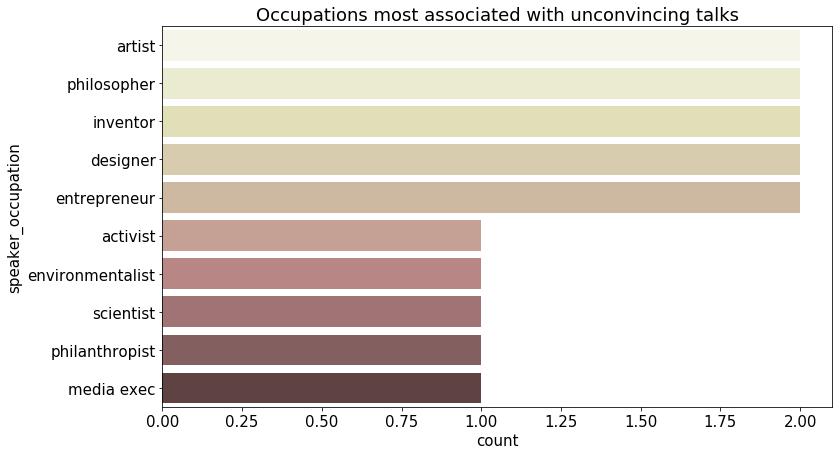

In [24]:
unconvincing_occupations = occupations_ratings[occupations_ratings['top_rating'] == 'unconvincing'][['top_rating', 'speaker_occupation']]
top_unconvincing_occupations = unconvincing_occupations.groupby('speaker_occupation').count().sort_values('top_rating', ascending=False).head(10)
top_unconvincing_occupations.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.barplot(y='speaker_occupation', x='top_rating', data=top_unconvincing_occupations, palette='pink_r' )
plt.title('Occupations most associated with unconvincing talks')
plt.xlabel('count');

### Transcripts EDA

To explore more on the data that that we would be modeling, we will create a column where persuasive votes exceed the median number of persuasive votes and label it as 1. If it does not exceed the median, then it will be labeled as 0.
The same will be done for inspiring talks. 

The reason for doing these is because persuasive and inspiring words tend to be overlapping and both have the power to sway people's decisions. We will look at a Venn diagram depicting that later. If the words do overlap, we have reason to classify both persuasive and inspiring in our modeling. 

In [25]:
# Assign 1 to talks whose count of persuasive votes is equal to or higher than the median
# These will be the classes that we will train the model on
persuasive_median = ted_model['persuasive'].median()

ted_model['persuasive_label'] = np.where(ted_model['persuasive'] >= persuasive_median, 1, 0)

#Do the same for inspiring talks and unconvincing talks
inspiring_median = ted_model['inspiring'].median()
ted_model['inspiring_label'] = np.where(ted_model['inspiring'] >= inspiring_median, 1, 0)

unconvincing_median = ted_model['unconvincing'].median()
ted_model['unconvincing_label'] = np.where(ted_model['unconvincing'] >= unconvincing_median, 1, 0)

We will lemmatize the words before visualising the words in the transcripts so that the words with the same root will not be repeatedly visualised. We will also remove stopwords and ensure that all the characters are lowercased.

In [26]:
def lemmastop(word):
    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #remove if words from stoplist or words with http or '/' in it
    if word in stopwords.words('english') or '/' in word:
        word = ''
        
    # Lemmatize word then remove any non word characters not catched in previous steps
    p_word = re.sub('\W+', '',lemmatizer.lemmatize(word))
    
    # returns processed words
    return p_word

def clean_data(raw_string):
    # The input is raw unprocessed text), and 
    # the output is preprocessed text)
    # Instantiate Tokenizer. 
    tokenizer = RegexpTokenizer(r'\w+\'?\w+(?=\W)') # Regex matches words and words with apostrophe in between
    
    # Tokenize raw string
    tokens = tokenizer.tokenize(raw_string.lower())  
    
    # call function to remove stop list words and lemmatize words
    processed_tokens = map(lemmastop, tokens)
    
    # Joins only tokens with words and returns processed string
    return ' '.join(token for token in processed_tokens if token != '')

# Apply the function to the transcript
ted_model['transcript'] = ted_model['transcript'].apply(clean_data)

In [27]:
# Remove transcripts that are empty from the dataframe since non-word characters have been removed
ted_model = ted_model[ted_model.transcript != '']

In [28]:
# Function to count vectorize and place the count of words into a dataframe
def count_words(data, num):
    
    # Instantiate Count Vectorizer with stopwords to remove them
    tf = CountVectorizer(stop_words = 'english')
    # Fit and transform the data with Count Vectorizer
    data_tf = tf.fit_transform(data).todense()
    # Change it into dataframe
    data_tf_df = pd.DataFrame(data_tf, columns = tf.get_feature_names())
    
    # Get a column containing the count of words called total and 
    # create a new dataframe with only the total and word columns
    data_total = pd.DataFrame(data_tf_df.sum(axis=0), columns=['total']).reset_index()
    data_total.rename({'index': 'word'}, axis=1, inplace=True)
    
    # Get the top words in the speeches
    top_data = data_total.sort_values(by='total', ascending=False).head(num)
    return top_data

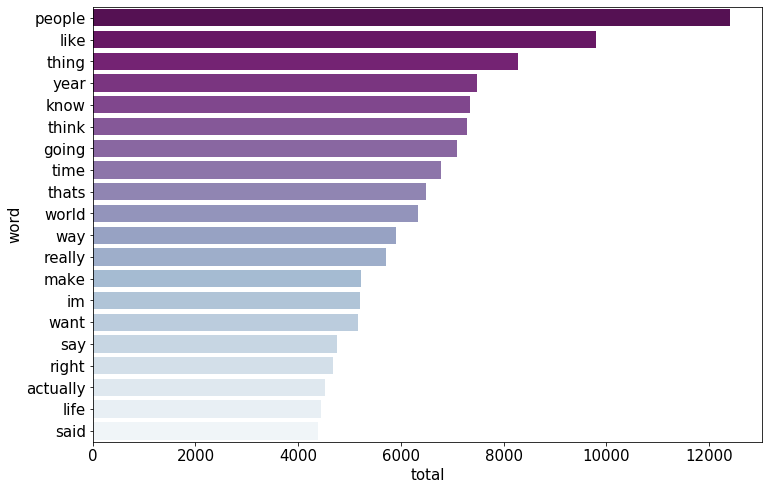

In [29]:
# Pick out the persuasive talks
persuasive = ted_model[ted_model['persuasive_label'] == 1]

# Plot the top inspiring words
top_persuasive = count_words(persuasive['transcript'], 20)
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_persuasive, palette='BuPu_r');

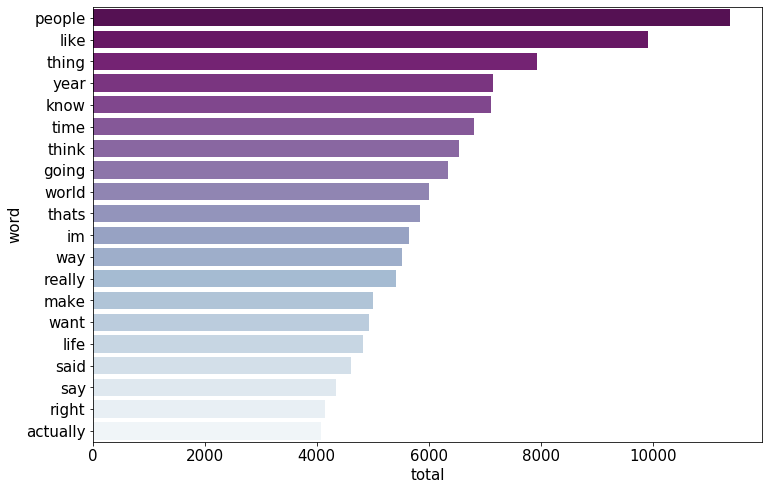

In [30]:
# Pick out the inspiring talks
inspiring = ted_model[ted_model['inspiring_label'] == 1]

# Plot the top inspiring words
top_inspiring = count_words(inspiring['transcript'], 20)
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_inspiring, palette='BuPu_r');

As expected, the top 5 words for persuasive are identical even in terms of the order. To take an even better look at their similarities, we will look at a Venn diagram.

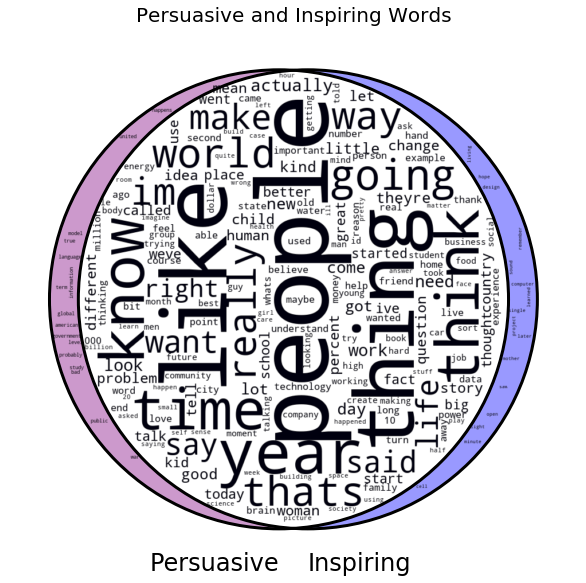

In [31]:
# Get the top 200 words from each type of talk 
top_200_persuasive = count_words(persuasive['transcript'], 200)
top_200_inspiring = count_words(inspiring['transcript'], 200)

# Get the word frequencies from the data frames above to be used in venn diagram
frequencies = dict()

for index, row in top_200_persuasive.iterrows(): 
    frequencies[row["word"]] = row["total"]
    
for index, row in top_200_inspiring.iterrows(): 
    if row["word"] in frequencies:
        frequencies[row["word"]] += row["total"]
    else:
        frequencies[row["word"]] = row["total"]
        
# Create visualisation
fig, ax = plt.subplots(figsize=(22,10))
ax.set_title('Persuasive and Inspiring Words', fontsize=20)
v = venn2_wordcloud([set(top_200_persuasive['word']), set(top_200_inspiring['word'])],
                    ax=ax, 
                    set_labels=["Persuasive", "Inspiring"],
                    word_to_frequency=frequencies)

# add color
v.get_patch_by_id('10').set_color('purple')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('blue')
v.get_patch_by_id('01').set_alpha(0.4);

As expected there are many overlapping words between persuasive and inspiring. And we can also see that TED Talks cover a wide range of topics that allow for diversity in the words that appear here. 

In [32]:
# Select columns of interest for modeling
ted_model = ted_model[['comments', 'views', 'transcript', 'persuasive_label', 'inspiring_label', 'unconvincing_label']]

In [33]:
ted_model.head()

,comments,views,transcript,persuasive_label,inspiring_label,unconvincing_label
0,4553,47227110,good morning great ive blown away whole thing ...,1,1,1
1,265,3200520,thank much chris truly great honor opportunity...,1,1,1
2,124,1636292,hello voice mail old friend ive called tech su...,1,0,1
3,200,1697550,today im happy heard sustainable development s...,1,1,1
4,593,12005869,10 year ago took task teach global development...,1,1,1


There are some talks that have multiple labels. We can visualise how many of these talks are multilabel.

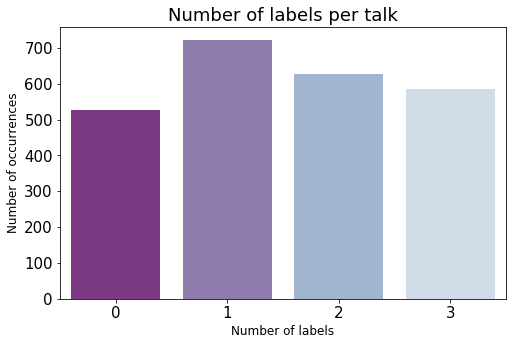

In [41]:
# Prepare the data for plotting
label_sums = ted_model.iloc[:,3:].sum(axis=1)
x = label_sums.value_counts()

# Plotting
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, palette='BuPu_r')
plt.title("Number of labels per talk")
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of labels', fontsize=12);

Most talks have at least one label assigned to it. About a little more than 500 talks do not have any label. 

## Data Export

Save the preprocessed transcripts in the dataframe ted_model to be used in the next notebook.

In [35]:
ted_model.to_csv('../data/ted_model.csv', index=False)